- 이 파일은 Baseline 용도로 만든거니까 꼭 이 형식에 얽메일 필요는 없어요!

## Import modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentencepiece

In [3]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 26.7 MB/s eta 0:00:00


In [4]:
# 모듈은 추가해주시면 됩니다. 필요한거
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import time
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import urllib.request

import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
import sentencepiece as spm

from collections import Counter, defaultdict


from collections import Counter, defaultdict


- 폰트 설정

In [5]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install mecab-python3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121747 files and direc

In [6]:
plt.rc('font', family='NanumBarunGothic')

## DataLoader - 데이터 전처리된 데이터셋을 가져옴. labeling 된거

* ratings_train.txt: 훈련용으로 사용되는 15만 개의 리뷰
* ratings_test.txt: 테스트용으로 보류된 5만 개의 리뷰
* 10만 개의 부정적 리뷰 (원래 1-4점의 리뷰)
* 10만 개의 긍정적 리뷰 (원래 9-10점의 리뷰)

In [7]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7e762e4a9c30>)

In [8]:
train_data = pd.read_table('ratings_train.txt')
train_data = train_data.dropna()
test_data = pd.read_table('ratings_test.txt')
test_data = test_data.dropna()

In [9]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## EDA

In [11]:
# 데이터 개수
print(train_data.shape) # (150000, 3)
print(test_data.shape) # (50000, 3)

(149995, 3)
(49997, 3)


<Axes: xlabel='label', ylabel='count'>

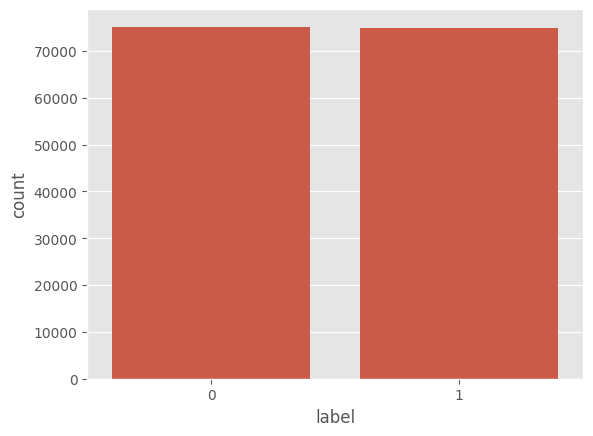

In [12]:
# 클래스 분포 확인 (0: 부정, 1: 긍정)
plt.style.use('ggplot')
sns.countplot(x='label', data=train_data)

<Axes: title={'center': 'Top 10 Train Words'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47568 (\N{HANGUL SYLLABLE MAL}) missing from current font.
  func(

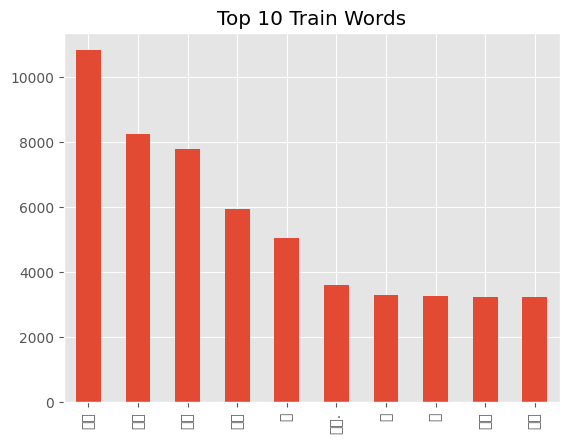

In [13]:
# 단어 빈도 분석 (train)
word_freq_train = train_data['document'].str.split(expand=True).stack().value_counts()
word_freq_train[:10].plot(kind='bar', title='Top 10 Train Words')

<Axes: title={'center': 'Top 10 Test Words'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47568 (\N{HANGUL SYLLABLE MAL}) missing from current font.
  func(

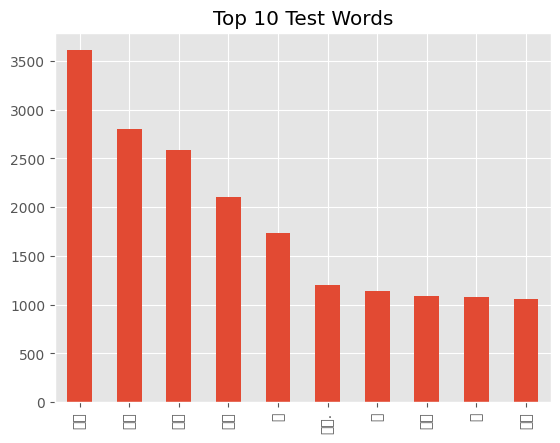

In [14]:
word_freq_test = test_data['document'].str.split(expand=True).stack().value_counts()
word_freq_test[:10].plot(kind='bar', title='Top 10 Test Words')

리뷰의 최대 길이 : 146
리뷰의 평균 길이 : 35.204526817560584


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

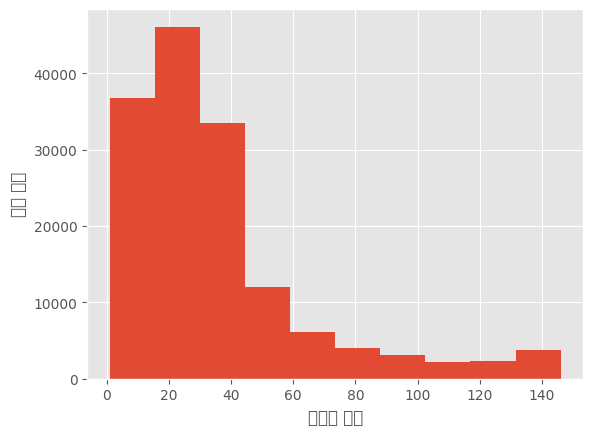

In [15]:
print('리뷰의 최대 길이 :', max([len(str(review)) for review in train_data['document']])) # 146
print('리뷰의 평균 길이 :', np.mean([len(str(review)) for review in train_data['document']])) # 35.20
plt.hist([len(str(review)) for review in train_data['document']])
plt.xlabel('문장의 길이')
plt.ylabel('샘플 개수')
plt.show()

## 토큰화 (Tokenizing)
### 결측값, 불용어 제거


In [16]:
# 결측값 확인
print('train data 결측값:', train_data['document'].isnull().sum())
print('test data 결측값:', test_data['document'].isnull().sum())

train data 결측값: 0
test data 결측값: 0


In [17]:
# 중복데이터 확인-train
print('중복데이터 개수(train) :',train_data[train_data['document'].duplicated()].shape[0])
train_data[train_data['document'].duplicated()].head()

중복데이터 개수(train) : 3813


,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1


In [18]:
# 중복데이터 확인 - test
print('중복데이터 개수(test) :',test_data[test_data['document'].duplicated()].shape[0])
test_data[test_data['document'].duplicated()].head()

중복데이터 개수(test) : 840


,id,document,label
857,2084375,bad,0
956,195683,재미있어요,1
1089,2235528,볼만함,1
1149,4409686,굿,1
1600,3805716,최고,1


In [19]:
# 중복 데이터 제거후 데이터 수
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print('중복데이터 제거 후 train 데이터 수 :',train_data.shape[0])
print('중복데이터 제거 후 test 데이터 수 :',test_data.shape[0])

중복데이터 제거 후 train 데이터 수 : 146182
중복데이터 제거 후 test 데이터 수 : 49157


In [20]:
# 결측치 제거
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test_data['document'].replace('', np.nan, inplace=True)

print('결측값 수(train) :', train_data['document'].isnull().sum())
print('결측값 수(test) :',test_data['document'].isnull().sum())

<ipython-input-20-7eaf880e0d0e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


결측값 수(train) : 0
결측값 수(test) : 0


<ipython-input-20-7eaf880e0d0e>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [21]:
# 총 데이터 수
print('train :', train_data.shape[0])
print('test :', test_data.shape[0])

train : 146182
test : 49157


### Tokenizing

In [22]:
sp = spm.SentencePieceProcessor()
sp.load('/content/drive/MyDrive/dataset/naver_review/naver_review.model')  # 모델 경로 설정

# 토크나이저 함수 정의
def tokenizer(text):
    return sp.encode_as_pieces(text)

In [23]:
# 데이터프레임 'train_data'에서 'document' 열을 기반으로 SentencePiece로 문장 토큰화
for i, (line) in enumerate(train_data['document']):
    # 출력: 현재 처리 중인 문장
    print("Original Sentence:", line)

    # 출력: SentencePiece를 사용하여 Subword로 토큰화한 결과
    print("Tokenized by Subword:", sp.encode_as_pieces(line))

    # 출력: Subword를 ID로 매핑한 결과
    print("Token IDs:", sp.encode_as_ids(line))
    if i == 5:
        break

Original Sentence: 아 더빙.. 진짜 짜증나네요 목소리
Tokenized by Subword: ['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']
Token IDs: [14, 1226, 7, 88, 2990, 55, 2393]
Original Sentence: 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
Tokenized by Subword: ['▁흠', '...', '포스터', '보고', '▁초딩', '영화', '줄', '....', '오', '버', '연기', '조차', '▁가볍', '지', '▁않', '구나']
Token IDs: [1949, 16, 5829, 233, 1469, 10, 6601, 47, 6454, 6564, 355, 2103, 2338, 6387, 108, 508]
Original Sentence: 너무재밓었다그래서보는것을추천한다
Tokenized by Subword: ['▁너무', '재', '밓', '었다', '그래서', '보는', '것을', '추천', '한다']
Token IDs: [39, 6416, 1, 164, 4556, 515, 1409, 2176, 367]
Original Sentence: 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
Tokenized by Subword: ['▁교', '도', '소', '▁이야기', '구', '먼', '▁..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조', '정']
Token IDs: [729, 6392, 6487, 372, 6478, 6879, 516, 5346, 1686, 309, 7, 1187, 188, 6424]
Original Sentence: 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
Tokenized by Subword: ['▁사이', '몬', '페', '그', '의', '▁익', '살', '스런', '▁연기가',

- 주어진 출력 결과는 각 문장에 대해 SentencePiece를 사용하여 Subword로 토큰화한 결과.
- 각 문장에 대해
1. 원본 문장,
2. Subword로 토큰화된 리스트,
3. 그리고 각 토큰에 대한 ID 리스트가 출력되어 있습니다.

In [24]:
# [SEP] 토큰의 ID 확인, [SEP]: Transformer 모델에서 문장 분리, 문장 간의 경계를 나타내기 위해 사용
# [SEP] 토큰은 문장의 시작과 끝을 나타내어 모델이 각 문장을 구분할 수 있도록 도와줌.
eos_token = '[SEP]'
eos_id = sp.piece_to_id(eos_token)

print(f"토큰 '{eos_token}'의 ID: {eos_id}")

토큰 '[SEP]'의 ID: 4


In [25]:
# 토큰에 대한 ID
sp.encode_as_ids(['[EOS]'])

[[4379, 7127, 6566, 6866, 7344]]

In [26]:
# 훈련 데이터셋 토큰화 및 텐서 변환
train_text = []  # 훈련 데이터를 저장할 리스트

# 각 문장에 대해 반복
for i, line in enumerate(train_data['document']):
    # SentencePiece를 사용하여 현재 문장(line)을 Subword로 토큰화하고, 그 결과를 TensorFlow 텐서로 변환
    subword_tokens = sp.encode_as_ids(line)
    tensorized_tokens = tf.convert_to_tensor(subword_tokens, dtype=tf.int32)

    # 변환된 텐서를 리스트에 추가
    train_text.append(tensorized_tokens)

# 테스트 데이터셋 토큰화 및 텐서 변환
test_text = []  # 테스트 데이터를 저장할 리스트

# 각 문장에 대해 반복
for i, line in enumerate(test_data['document']):
    # SentencePiece를 사용하여 현재 문장(line)을 Subword로 토큰화하고, 그 결과를 TensorFlow 텐서로 변환
    subword_tokens = sp.encode_as_ids(line)
    tensorized_tokens = tf.convert_to_tensor(subword_tokens, dtype=tf.int32)

    # 변환된 텐서를 리스트에 추가
    test_text.append(tensorized_tokens)


In [27]:
print(len(train_text), len(test_text))

146182 49157


### Padding and truncating data using pad sequences
* 전부 길이가 다른 리뷰들의 길이를 통일해 주겠습니다.

In [28]:
batch_size = 32 # 모델이 한번에 처리하는 샘플의 수
max_seq_length = 160 # 모델이 처리할 수 있는 최대 문장 길이를 제한하는 값

- padding: 시퀀스 데이터에서 각 샘플의 길이를 맞추기 위해 추가되는 가상의 값 또는 토큰

In [29]:
# 훈련 데이터셋 패딩 처리
train_data_pad = pad_sequences(train_text,
                               maxlen=max_seq_length,  # 최대 시퀀스 길이
                               padding='post',  # 패딩을 시퀀스의 뒷부분에 추가
                               value=0)  # 패딩 값은 0으로 설정

# 테스트 데이터셋 패딩 처리
test_data_pad = pad_sequences(test_text,
                              maxlen=max_seq_length,  # 최대 시퀀스 길이
                              padding='post',  # 패딩을 시퀀스의 뒷부분에 추가
                              value=0)  # 패딩 값은 0으로 설정

### Dataset 구성

- shuffle(10000): 훈련 데이터셋을 섞는데, 버퍼 크기를 10000으로 지정하여 섞입니다.


In [30]:
# for train
# 훈련 데이터셋을 tf.data.Dataset으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_pad, train_data['label']))

# 데이터를 섞고 반복하며 배치 생성
train_dataset = train_dataset.shuffle(10000).repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
# 테스트 데이터셋을 tf.data.Dataset으로 변환
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_pad, test_data['label']))

# 배치 생성
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<_BatchDataset element_spec=(TensorSpec(shape=(None, 160), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 160), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### Model Build
- parameter 설정

https://bigbread-1129.notion.site/Transformer-bf23ca82d6664422a00133db74d4c4b3?pvs=4


In [31]:
# 모델 설정을 위한 매개변수들
kargs = {
    'model_name': 'BERT',  # 사용할 모델의 이름 (여기서는 BERT)
    'num_layers': 12,  # Transformer 레이어의 개수 (12-Basic BERT, 24-Large BERT)
    'd_model': 512,  # 모델의 임베딩 차원
    'num_heads': 8,  # Multi-head 어텐션에서 사용할 헤드의 개수
    'dff': 2048,  # Feedforward 신경망의 은닉층 차원
    'input_vocab_size': sp.get_piece_size(),  # 입력 어휘 집합 크기
    'target_vocab_size': sp.get_piece_size(),  # 타겟 어휘 집합 크기
    'maximum_position_encoding': 160,  # 입력 시퀀스의 최대 위치 인코딩 값
    'segment_encoding': 2,  # 세그먼트 인코딩 (일반적으로 사용하지 않는 매개변수)
    'end_token_idx': sp.piece_to_id('[EOS]'),  # 종료 토큰의 인덱스
    'rate': 0.1  # 드롭아웃 비율
}


- Positional Encoding(포지셔널 인코딩)은 Transformer 모델에서 시퀀스의 단어의 상대적인 위치 정보를 모델에 제공하기 위한 기술.
- Transformer는 어순 정보를 고려하지 않는 self-attention 메커니즘을 사용하므로, 문장 내 단어의 순서 정보를 잃을 수 있습니다.
- 이를 보완하기 위해 Positional Encoding이 도입

In [32]:
def get_angles(pos, i, d_model):
    """
    포지셔널 인코딩을 위한 각도를 계산합니다.

    매개변수:
    - pos (int): 시퀀스 내의 위치입니다.
    - i (int): 각도의 인덱스입니다.
    - d_model (int): 모델의 차원 크기입니다.

    반환값:
    - float: 포지셔널 인코딩을 위해 계산된 각도입니다.
    """
    # 각도 비율을 계산하여 angle_rates에 저장
    angle_rates = 1 / np.power(10000, (2 * i // 2) / np.float32(d_model))

    # 위치(pos)에 계산된 각도 비율을 곱하여 반환
    return pos * angle_rates


In [33]:
def positional_encoding(position, d_model):
    # 1. 포지션과 차원의 인덱스에 대한 각도 계산
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # 2. 사인 함수를 짝수 인덱스에, 코사인 함수를 홀수 인덱스에 적용
    #    홀수 인덱스는 2i+1, 짝수 인덱스는 2i에 해당
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # 3. 최종적으로 포지셔널 인코딩을 반환
    pos_encoding = angle_rads[np.newaxis, ...]

    # 4. TensorFlow의 자료형으로 변환하여 반환
    return tf.cast(pos_encoding, dtype=tf.float32)


In [34]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    스케일드 닷 프로덕트 어텐션을 계산합니다.

    Args:
    - q: 쿼리 텐서, shape == (..., seq_len_q, depth)
    - k: 키 텐서, shape == (..., seq_len_k, depth)
    - v: 값 텐서, shape == (..., seq_len_v, depth_v)
    - mask: 어텐션 마스크 텐서, shape은 (..., seq_len_q, seq_len_k)와 broadcastable해야 합니다. 기본값은 None입니다.

    Returns:
    - output: 어텐션 가중 평균을 계산한 결과 텐서, shape == (..., seq_len_q, depth_v)
    - attention_weights: 어텐션 가중치 텐서, shape == (..., seq_len_q, seq_len_k)
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 유사도를 스케일링
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 마스크를 스케일드 텐서에 추가
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # 소프트맥스는 마지막 축(seq_len_k)을 기준으로 정규화되어 각 위치에 대한 가중치가 계산됨
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    # 가중치를 사용하여 값에 대한 가중 평균 계산
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


In [35]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()

        # 설정된 파라미터로 레이어 초기화
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        # d_model이 num_heads로 나누어 떨어지는지 확인
        assert self.d_model % self.num_heads == 0

        # 각 헤드의 차원
        self.depth = self.d_model // self.num_heads

        # 각각의 가중치 행렬을 정의
        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        # 최종 출력을 위한 밀집 레이어
        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        """마지막 차원을 (num_heads, depth)로 분할합니다.
        결과를 (batch_size, num_heads, seq_len, depth)로 전치합니다.
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # 쿼리(Q), 키(K), 값(V)에 각각 가중치 행렬 적용
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # 각 어텐션 헤드로 분할
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        # 어텐션 헤드의 차원을 변경
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        # 모든 어텐션 헤드를 결합
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # 최종 출력을 위해 밀집 레이어 통과
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights


In [36]:
# point-wise feed-forward network를 정의한 케라스 Sequential 모델을 반환합니다.
def point_wise_feed_forward_network(**kargs):
  return tf.keras.Sequential([
        tf.keras.layers.Conv1D(kargs['dff'], 1, activation='relu'), #TODO - 1D Convolutional Layer
        # 이 레이어는 입력의 각 위치에 대해 독립적으로 적용되며, 학습 가능한 가중치를 사용합니다.
        # kargs['dff']: 2048 - Conv1D의 출력 차원 (은닉층 차원)

        tf.keras.layers.Conv1D(kargs['d_model'],1)  #TODO - 1D Convolutional Layer
        # 이 레이어는 두 번째 Conv1D 레이어로, 출력 차원은 kargs['d_model']로 지정됩니다.
        # 이는 Transformer의 특정 레이어 구조에 따라 은닉층의 차원을 나타냅니다.
        # 이 레이어의 출력은 (batch_size, seq_len, d_model) 모양이 됩니다.
    ])


In [37]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        # Multi-Head Attention 레이어
        self.mha = MultiHeadAttention(**kargs)

        # 포인트 와이즈 피드 포워드 네트워크
        self.ffn = point_wise_feed_forward_network(**kargs)

        # 레이어 정규화
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # 드롭아웃 레이어
        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    @tf.function
    def call(self, x, mask):
        # Multi-Head Attention 수행
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)

        # 레이어 정규화 및 잔차 연결
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        # 포인트 와이즈 피드 포워드 네트워크 수행
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)

        # 레이어 정규화 및 잔차 연결
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_output


In [38]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        # 입력 및 레이어 관련 파라미터 설정
        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        # 임베딩 레이어 및 위치 인코딩 설정
        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'],
                                                   self.d_model)
        self.seg_encoding = tf.keras.layers.Embedding(kargs['segment_encoding'],
                                                     self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'],
                                                self.d_model)

        # 여러 개의 인코더 레이어 설정
        self.enc_layers = [EncoderLayer(**kargs)
                           for _ in range(self.num_layers)]

        # 드롭아웃 레이어 설정
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def get_seg_data(self, data, token_id=4):
        # 세그먼트 정보 추출
        token_found = tf.cumsum(tf.cast(data == token_id, tf.int32), axis=1)
        modified_data = tf.cast(token_found >= 1, tf.int32)

        return modified_data

    def call(self, x, mask):
        attn = None
        seq_len = tf.shape(x)[1]  # 입력 텐서의 시퀀스 길이를 가져옵니다.
        seg_data = self.get_seg_data(x)  # 세그먼트 정보를 추출하는 함수를 호출합니다.

        # 임베딩과 위치 인코딩 추가
        x = self.embedding(x)  # (배치 크기, 입력 시퀀스 길이, 임베딩 차원)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # 임베딩 차원에 루트를 취해줌 - 스케일 조정
        x += self.pos_encoding[:, :seq_len, :]  # 위치 인코딩을 더합니다.

        x += self.seg_encoding(seg_data)  # 세그먼트 인코딩을 더합니다.

        x = self.dropout(x)  # 드롭아웃을 적용합니다.

        for i in range(self.num_layers):
            x, attn = self.enc_layers[i](x, mask)

        return x, attn  # (배치 크기, 입력 시퀀스 길이, 임베딩 차원)


In [39]:
class BERT(tf.keras.Model):
    def __init__(self, **kargs):
        super(BERT, self).__init__(name=kargs['model_name'])

        # 클래스 초기화
        self.end_token_idx = kargs['end_token_idx']
        self.encoder = Encoder(**kargs)
        self.outputs_layer = tf.keras.layers.Dense(kargs['d_model'],
                                                   activation='tanh')

        self.final_layer = tf.keras.layers.Dense(2)

    def create_padding_mask(self, seq):
        # 패딩 마스크 생성
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

        # add extra dimensions to add the padding
        # to the attention logits.
        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

    def call(self, x):
        inp = x
        mask = self.create_padding_mask(inp)

        # Transformer 인코더에 입력과 마스크 전달
        enc_output, attn = self.encoder(inp, mask)  # (batch_size, inp_seq_len, d_model)

        # 출력 레이어 적용
        enc_output = self.outputs_layer(enc_output)  # (batch_size, inp_seq_len, d_model)

        # 플래튼 레이어를 사용하여 2D 텐서를 1D로 변환
        enc_output = tf.keras.layers.Flatten()(enc_output)  # (batch_size, inp_seq_len * d_model)

        # 최종 출력 레이어 적용
        final_output = self.final_layer(enc_output)  # (batch_size, 2)

        return final_output


In [40]:
model = BERT(**kargs)

## Model Training

In [41]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    # 패딩된 부분을 마스킹하여 손실 계산
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    # 패딩된 부분을 마스킹하여 정확도 계산
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)


In [42]:
# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Adam 옵티마이저 사용, 학습률은 1e-4로 설정
    loss=loss,  # 손실 함수로 앞서 정의한 loss 함수 사용
    metrics=[accuracy]  # 정확도를 평가 지표로 사용, 여기서는 앞서 정의한 accuracy 함수 사용
)

In [43]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10,  # 검증 손실이 patience 횟수 동안 감소하지 않으면 훈련 중단
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료 여부 판단
    restore_best_weights=True,  # 가장 좋은 성능을 보인 모델 가중치로 복원
    verbose=1  # 조기 종료 동작을 출력
)

In [ ]:
history = model.fit(
    train_dataset,  # 훈련 데이터셋
    epochs=20,  # 최대 에폭 수
    validation_data=test_dataset,  # 검증 데이터셋
    steps_per_epoch=len(train_data_pad) // batch_size,  # 한 에폭당 훈련 단계 수
    validation_steps=len(test_data_pad) // batch_size,  # 한 에폭당 검증 단계 수
    callbacks=[early_stopping_cb]  # 조기 종료 콜백 사용
)


Epoch 1/20
4568/4568 [==============================] - 2679s 576ms/step - loss: 0.3768 - accuracy: 0.7688 - val_loss: 0.3771 - val_accuracy: 0.7633
Epoch 2/20
1289/4568 [=======>......................] - ETA: 28:08 - loss: 0.3768 - accuracy: 0.7599

## Model Test

In [ ]:
results = model.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.3f}".format(results[1]))